**Q1. Explain what problem you are going to solve using this dataset. Provide a brief overview of your problem statement.**  

**Problem Statement**    
**Title**: Analyzing Weather Impact on Bike Rental Demand and Predicting Future Rentals based on Weather conditions.  
**Objective**: Aiming to achieve two primary goals:  
> 1. Weather Impact Analysis: Conduct a descriptive analysis to understand how various weather conditions affect bike rental demand in the Capital Bike share system.  
> 2. Predictive Modeling: Develop a machine learning model to forecast the number of bike rentals by using weather conditions, seasons factors, and other relevant features.    
     

**Overview**: Bike sharing systems are integral to urban transportation, offering a convenient, eco-friendly, and health-promoting alternative to traditional transport modes. However, the demand for bike rentals can be highly variable, influenced by weather conditions, time of day, and other factors. Optimizing the availability and distribution of bikes requires a thorough understanding of these influences.

**Import libraries**

In [1]:
%pip install -U azureml-fsspec

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pip
pip.main(['install','seaborn'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting seaborn

Downloading seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)

Requirement already satisfied: numpy!=1.24.0,>=1.20 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from seaborn) (1.26.4)

Requirement already satisfied: pandas>=1.2 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from seaborn) (2.2.2)

Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from seaborn) (3.9.0)

Requirement already satisfied: contourpy>=1.0.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.2.1)

Requirement already satisfied: cycler>=0.10 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (0.12.1)

Requirement already satisfied: fonttools>=4.22.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (4.53.0)

Requirement already satisfied: kiwisolver>=1.3.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.4.5)

Requirement already satisfied: packaging>=20.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (24.0)

Requirement already satisfied: pillow>=8 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (10.3.0)

Requirement already satisfied: pyparsing>=2.3.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (3.1.2)

Requirement already satisfied: python-dateutil>=2.7 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (2.9.0)

Requirement already satisfied: pytz>=2020.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from pandas>=1.2->seaborn) (2024.1)

Requirement already satisfied: tzdata>=2022.7 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from pandas>=1.2->seaborn) (2024.1)

Requirement already satisfied: six>=1.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from python-dateutil>=2.7->matplotlib!=3.6.1,>=3.4->seaborn) (1.16.0)

Downloading seaborn-0.13.2-py3-none-any.whl (294 kB)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pip/_vendor/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Installing collected packages: seaborn

Successfully installed seaborn-0.13.2

0

In [5]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

**Load the data**: Create a handle and load the dataset

In [6]:
# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="8327bba7-fe34-4042-a7f0-c0e06095a470",
    resource_group_name="ass5part2",
    workspace_name="amlass5part2",
)

No environment configuration found.

ManagedIdentityCredential will use Azure ML managed identity

In [8]:
# update the 'my_path' variable to match the location of where you downloaded the data on local filesystem

my_path = "./data/day.csv"
# set the version number of the data asset
v1 = "initial"

my_data = Data(
    name="bike_sharing_day",
    version=v1,
    description="Bike share information in day basis",
    path=my_path,
    type=AssetTypes.URI_FILE,
)

## create data asset if it doesn't already exist:
try:
    data_asset = ml_client.data.get(name="bike_sharing_day", version=v1)
    print(
        f"Data asset already exists. Name: {my_data.name}, version: {my_data.version}"
    )
except:
    ml_client.data.create_or_update(my_data)
    print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

Data asset already exists. Name: bike_sharing_day, version: initial


In [9]:
# get a handle of the data asset and print the URI
data_asset = ml_client.data.get(name="bike_sharing_day", version=v1)
print(f"Data asset URI: {data_asset.path}")

# read into pandas - note that you will see 2 headers in your data frame - that is ok, for now

df = pd.read_csv(data_asset.path)
df.head()

data = df.copy()

Data asset URI: azureml://subscriptions/8327bba7-fe34-4042-a7f0-c0e06095a470/resourcegroups/ass5part2/workspaces/amlass5part2/datastores/workspaceblobstore/paths/LocalUpload/04b9c330cb982abf65194f10173f9d6d/day.csv


No environment configuration found.

ManagedIdentityCredential will use Azure ML managed identity

DefaultAzureCredential acquired a token from ManagedIdentityCredential

AzureMLCredential.get_token succeeded

ManagedIdentityCredential.get_token succeeded

DefaultAzureCredential acquired a token from ManagedIdentityCredential

No environment configuration found.

ManagedIdentityCredential will use Azure ML managed identity

DefaultAzureCredential acquired a token from ManagedIdentityCredential

AzureMLCredential.get_token succeeded

ManagedIdentityCredential.get_token succeeded

DefaultAzureCredential acquired a token from ManagedIdentityCredential

**Q2. Explain your dataset. Explore your dataset and provide at least 5 meaningful charts/graphs with an explanation.**

**Plot 1. Daily Rental Trend Analysis**  
The following time series plot shows how bike rental counts have changed over time, revealing trends, seasonality, or any unusual patterns.

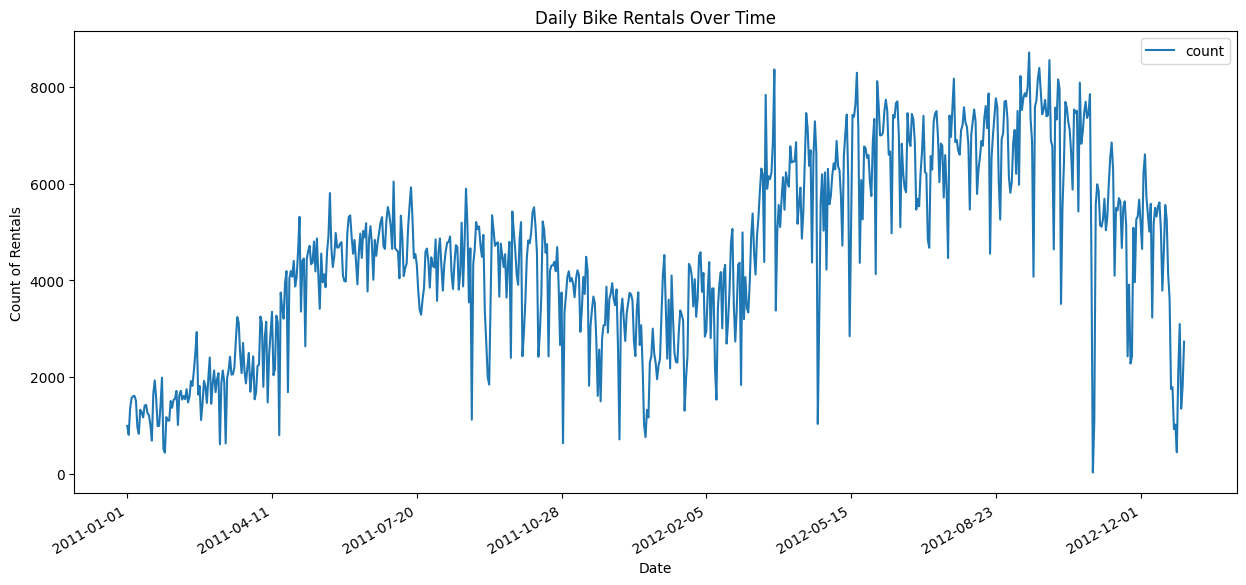

In [10]:
ax = data.plot('dteday',y='cnt', figsize=(15, 6))
ax.legend(["count"])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xlabel('Date')
plt.ylabel('Count of Rentals')
plt.title('Daily Bike Rentals Over Time')
plt.show()

**Explanation**: The above line graph represents the daily bike rentals over time, spanning from January 2011 to December 2012. It shows a clear upward trend in bike rentals, indicating increasing usage over the period, with seasonal fluctuations evident—rental counts peak during the warmer months and decrease during colder periods.

**Plot 2. Seasonal Impact on Rental Demand**  

The following pie chart shows the total bike rentals for each season, providing insights into how rental demand varies by season. 

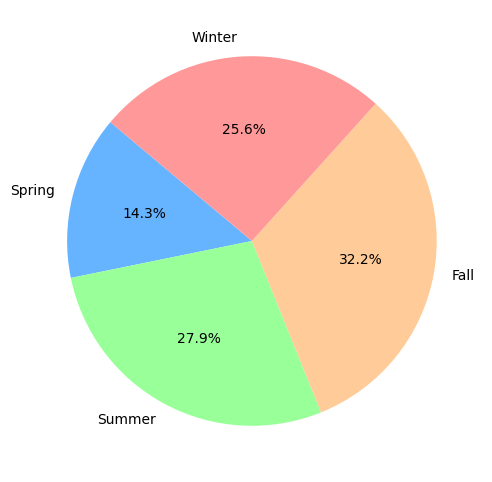

In [11]:
season_labels = ['Spring','Summer','Fall','Winter'];
season_cnt = data.groupby(['season'])['cnt'].sum()

plt.figure(figsize=(6, 6))
plt.pie(season_cnt,labels=season_labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99','#ff9999'])

plt.show()

**Explanation**: The pie chart illustrates the distribution of bike rentals across different seasons. The largest share of rentals occurs in the fall, accounting for 32.2% of the total, followed by summer with 27.9%, winter with 25.6%, and spring with the smallest share at 14.3%. This indicates that bike rentals are more popular during the fall and summer seasons, possibly due to more favorable weather conditions.

**Plot 3. Temperature vs. Rental Demand**

This following scatter plot with a regression line illustrates the relationship between normalized temperature and bike rental demand.

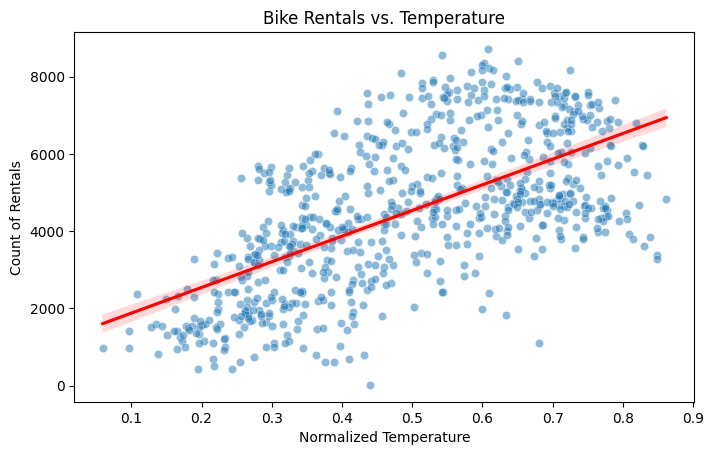

In [12]:
plt.figure(figsize=(8, 4.8))
sns.scatterplot(x='temp', y='cnt', data=data, alpha=0.5)
sns.regplot(x='temp', y='cnt', data=data, scatter=False, color='r')
plt.title('Bike Rentals vs. Temperature')
plt.xlabel('Normalized Temperature')
plt.ylabel('Count of Rentals')
plt.show()

**Explanation**: The scatter plot shows the relationship between normalized temperature and the count of bike rentals. There is a clear positive correlation, indicating that as the temperature increases, the number of bike rentals also tends to increase. The red line represents a linear trend line, suggesting a general upward trend where higher temperatures are associated with higher rental counts. However, there is also some variability around the trend line, indicating that other factors may also influence bike rentals.

**Plot 4. Weather Situation vs. Rental Demand**

The following box plot depicts the distribution of bike rentals across different weather conditions, helping to identify the impact of weather on rental demand.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

/tmp/ipykernel_3555/1705807439.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='weathersit', y='cnt', data=data, palette='coolwarm')


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

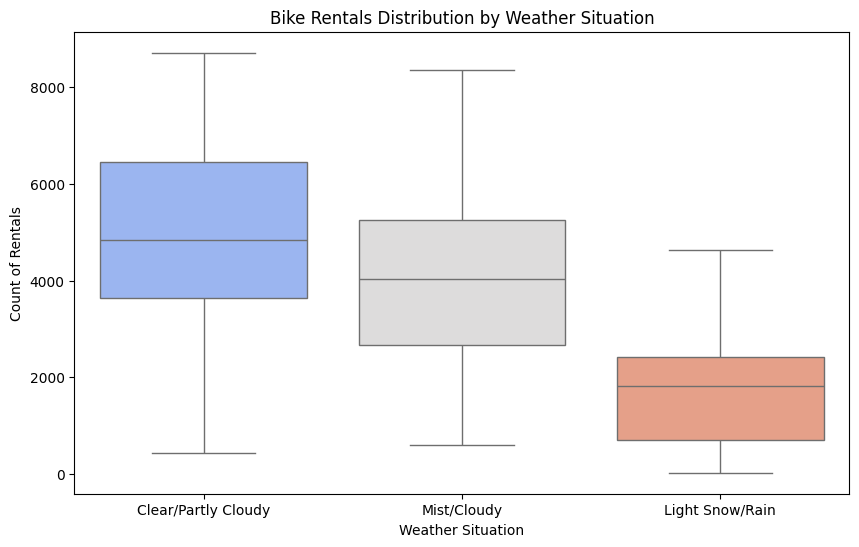

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='weathersit', y='cnt', data=data, palette='coolwarm')

plt.title('Bike Rentals Distribution by Weather Situation')
plt.xlabel('Weather Situation')
plt.ylabel('Count of Rentals')
plt.xticks([0, 1, 2], ['Clear/Partly Cloudy', 'Mist/Cloudy', 'Light Snow/Rain'])
plt.show()

**Explanation**: The box plot shows the distribution of bike rentals across different weather situations: Clear/Partly Cloudy, Mist/Cloudy, and Light Snow/Rain. The data reveals that bike rentals are highest during clear or partly cloudy conditions, with a median count around 5000 rentals. Rentals decrease under misty or cloudy conditions, with a median closer to 4000, and are lowest during light snow or rain, with a median below 2000. The variation in rental counts is also greater during clear weather, as shown by the wider interquartile range and longer whiskers, indicating that weather conditions significantly impact rental activity.

**Plot 5. Working Day vs. Non-working Day Rentals**

This following barplot compares bike rental counts between working days and non-working days, highlighting how rental behavior differs between these two types of days.

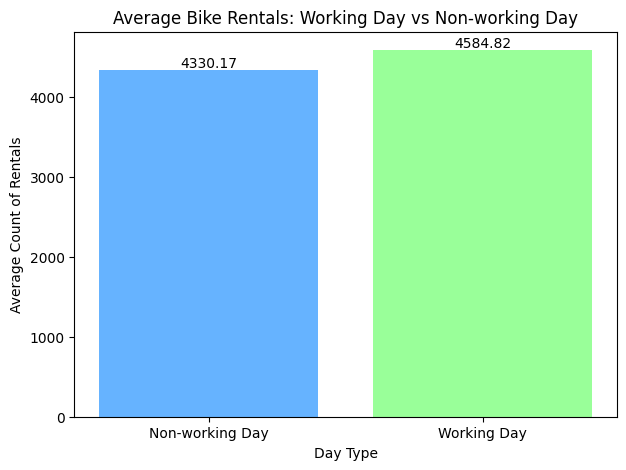

In [14]:
working_day_avg = data.groupby('workingday')['cnt'].mean().reset_index()
labels = ['Non-working Day', 'Working Day']

plt.figure(figsize=(7, 5))
bars = plt.bar(labels, working_day_avg['cnt'], color=['#66b3ff', '#99ff99'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')


plt.title('Average Bike Rentals: Working Day vs Non-working Day')
plt.xlabel('Day Type')
plt.ylabel('Average Count of Rentals')
plt.show()

**Explanation**: The bar chart compares the average bike rentals between working days and non-working days. The chart shows that bike rentals are slightly higher on working days, with an average of 4584.82 rentals compared to 4330.17 on non-working days. This suggests that people may be using bike rentals more for commuting or other regular activities during working days, although the difference is not very large, indicating consistent demand for bike rentals across both day types.

**Q3. Do data cleaning/pre-processing as required and explain what you have done for your dataset and why.**

**Q3-1. Select relevant columns**  

Our first objective is to analyze the relationship between weather conditions and rental demands, so we remove any dimensions in the dataset that are not relevant to weather, which includes "date", "holiday", "weekday", "working day", "casual" and "registered" columns.

In [15]:
df_weather = df.drop(['instant', 'dteday', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'casual', 'registered'], axis=1)
df_weather.head(5)

,season,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2,0.344167,0.363625,0.805833,0.160446,985
1,1,2,0.363478,0.353739,0.696087,0.248539,801
2,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,1,0.226957,0.229270,0.436957,0.186900,1600


**Q3-2. Handle Missing Values**  
  
From the result, it's clear that this dataset doesn't contain any missing value.

In [16]:
missing_values = df_weather.isnull().sum()
missing_values

season        0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

** Q3-3. Convert Categorical Variables**

Convert categorical variables (e.g., season, weathersit) into meaningful categories if they are not already, which can reduce memory usage and ensure that models treat them as discrete categories rather than continuous variables.

In [17]:
df_weather['season'] = df_weather['season'].astype('category')
df_weather['weathersit'] = df_weather['weathersit'].astype('category')

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      731 non-null    category
 1   weathersit  731 non-null    category
 2   temp        731 non-null    float64 
 3   atemp       731 non-null    float64 
 4   hum         731 non-null    float64 
 5   windspeed   731 non-null    float64 
 6   cnt         731 non-null    int64   
dtypes: category(2), float64(4), int64(1)
memory usage: 30.4 KB


**Q3-4. Deal with outliers**  

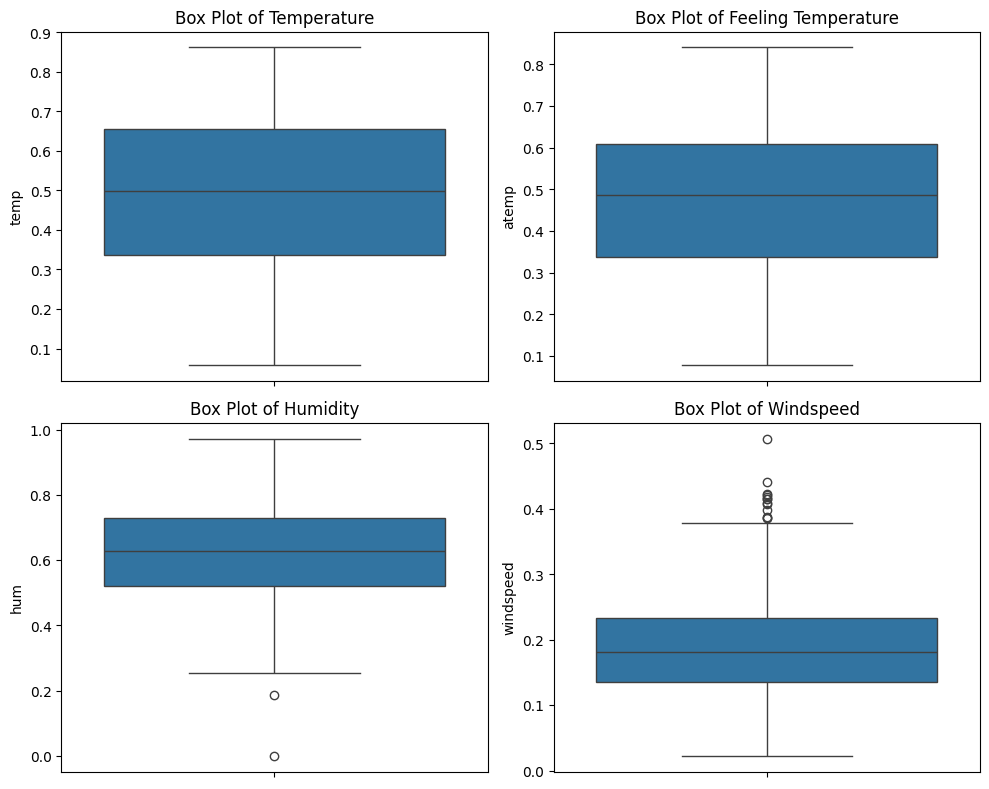

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.boxplot(data=df_weather['temp'], ax=axs[0, 0])
axs[0, 0].set_title('Box Plot of Temperature')

sns.boxplot(data=df_weather['atemp'], ax=axs[0, 1])
axs[0, 1].set_title('Box Plot of Feeling Temperature')

sns.boxplot(data=df_weather['hum'], ax=axs[1, 0])
axs[1, 0].set_title('Box Plot of Humidity')

sns.boxplot(data=df_weather['windspeed'], ax=axs[1, 1])
axs[1, 1].set_title('Box Plot of Windspeed')

plt.tight_layout()
plt.show()

In [19]:
# remove outliers
windspeed_upper_bound = df_weather.describe()["windspeed"]["75%"] + 1.5 * (df_weather.describe()["windspeed"]["75%"] - df_weather.describe()["windspeed"]["25%"])
humidity_lower_bound = df_weather.describe()["hum"]["25%"] - 1.5 * (df_weather.describe()["windspeed"]["75%"] - df_weather.describe()["windspeed"]["25%"])
df_weather = df_weather[(df_weather['hum'] >= humidity_lower_bound) & (df_weather['windspeed'] <= windspeed_upper_bound)]
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702 entries, 0 to 730
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      702 non-null    category
 1   weathersit  702 non-null    category
 2   temp        702 non-null    float64 
 3   atemp       702 non-null    float64 
 4   hum         702 non-null    float64 
 5   windspeed   702 non-null    float64 
 6   cnt         702 non-null    int64   
dtypes: category(2), float64(4), int64(1)
memory usage: 34.6 KB


**Data Cleaning Conclusion**

> 1. Dropped non-relevant columns
> 2. Checked missing values, no missing values exists.
> 3. Converted "season" and "weathersit" columns to meaningful categories, which is helpful model building.
> 4. Handled outliers. Found out the outliers by box-plots then removed the 29 outliers (from 731 records to 702 records). 

**Q4. Implement 2 machine learning models...**  

**Models**:
> 1. Linear Regression: We first apply the most fundamental machine learning model-linear regression model, which analyzes the relationship between bike share count and multiple independent weather variables.  
> 2. Random Forest Regression: It is an ensemble method that often outperforms simpler models like Linear Regression, especially when dealing with non-linear data.  

**Metrics**:
> 1. RMSE: A lower RMSE indicates better model performance. It measures the average magnitude of the errors between predicted and actual values.    
> 2. R²: R-squared indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R² indicates a better fit.

**Preprocessing**. 
> 1. The season column uses 1-4 to categorize 4 seasons, and the weathersit column use 1-4 to categorize 4 types of weather conditions, to prevent model to interpret any ordinal relationship, we should encode these two columns to One-Hot Encoding format.   
2. Also splitting the dataset into train and test sub-datasets.

In [21]:
# Define features columns for model, needs one-hot encoding
X = df_weather.iloc[:,:-1]
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot_season', OneHotEncoder(), ['season']),  # Apply OneHotEncoder to 'season' column
        ('onehot_category', OneHotEncoder(), ['weathersit'])  # Apply OneHotEncoder to 'weathersit' column
    ],
    remainder='passthrough'  # Keep the other columns unchanged
)
X = column_transformer.fit_transform(X)
Y = df_weather['cnt']


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

**Q4-1. Linear regression model**.

In [22]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

y_pred_lr = lr_model.predict(X_test)

rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Linear Regression R²: {r2_lr:.2f}")

Linear Regression RMSE: 1331.46
Linear Regression R²: 0.59


**Q4-2. Random Forest Regression model** 

In [59]:
# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regression RMSE: {rmse_rf:.2f}")
print(f"Random Forest Regression R²: {r2_rf:.2f}")

Random Forest Regression RMSE: 1272.19
Random Forest Regression R²: 0.62


**Q4-3. Comparison and Conclusion**

**Comparison**
> 1. RMSE: The Random Forest Regression has a lower RMSE (1272.19) compared to the Linear Regression (1331.46). This suggests that the Random Forest model is better at predicting the bike rental counts (cnt) and generally makes predictions that are closer to the actual rental numbers.
> 2. R-squared: The Random Forest Regression has a slightly higher R² (0.62) compared to the Linear Regression (0.59). This means that the Random Forest model explains slightly more variance in the bike rental counts than the Linear Regression model.

**Conclusion**

> 1. Random Forest Regression outperforms Linear Regression in this case, as indicated by the lower RMSE and higher R². This suggests that the Random Forest model is more accurate in predicting bike rental counts and better captures the underlying relationships in the data.  
> 2. However, the difference between the two models is not dramatic. This could indicate that while there are some non-linear patterns in the data, the overall relationship between the weather-related features and the target variable (cnt, the count of total rental bikes) might still be somewhat linear. Thus, while Random Forest is a better choice, Linear Regression is not entirely ineffective.

**Q5. Use Automated ML for your data set. Explain the best model results.**

**Step 1:** Prepare Cleaned dataset.
To operate an automated ML job, we need to prepare a cleaned data asset.   
we will transfer the pre-processed dataframe (df_weather)into a data asset.

In [18]:
#export df_weather to csv in data folder
df_weather.to_csv("./data/day_cleaned.csv")

> Directly download day_cleaned.csv  
> Upload as mltable in data asset named: data_clean
> *automated ML job only accept data asset in mltable type

**Step 2:** Create an Automated ML job   

> 1. Select the data asset that we just created   
> 2. Configure the ML job  
> * In task, specify it as "regression"   
> * Choose "cnt" column as targets, others as features  
> * In "view featurization settings" set "season" and "weathersit" column as "Categorical"  

> 3. Submit the job

<img src="./data/view_featurization_settings.png" width="50%" />

**Step3:** Analyze the result of the best model  

> In the best model summary section, VotingEssemble is considered to be the best model. With RMSE = 1186.96  
In "View essemble details" section, we can find that VotingEssemble mixes different normalizers and wrappers with different weights. The mix helps the essemble to capture various data characteristics. Weighted voting optimizes how much influence each model should have in the final prediction. Models that perform better on certain aspects of the data might be given more weight, leading to a more accurate overall prediction. 

<img src="./data/bestmodel_visualized.png" witdh="80%" >
<img src="./data/ensemble_details.png" width="80%" >